# Kernel Logistic Regression – Theory and Optimization Formulation

## 1. Discriminant Function with Kernel

We define the discriminant function for kernel logistic regression as:
$$
f(x) = P(C = 1|x) = \sigma(w^\top \Phi(x))
$$
where:
- $( \Phi(x) )$ is a mapping into a high-dimensional feature space,
- $( \sigma(z) = \frac{1}{1 + e^{-z}} )$ is the logistic function,
- $( w $) is expressed as a linear combination of training samples:

$$
w = \sum_{i=1}^\ell \alpha_i \Phi(x_i)
$$

Using the kernel trick:

$$
\langle \Phi(x_i), \Phi(x) \rangle = k(x_i, x)
$$

we can write the discriminant function as:

$$
f(x) = \sigma\left( \sum_{i=1}^\ell \alpha_i k(x_i, x) \right)
$$

---

## 2. Optimization Objective – Cross-Entropy Loss

To train the model, we minimize the **cross-entropy loss** over training data $ \{(x_t, y_t)\}_{t=1}^\ell $:

$$
\mathcal{L}(\alpha) = \sum_{t=1}^\ell \left[ - y_t \log \sigma\left( \sum_{i=1}^\ell \alpha_i k(x_i, x_t) \right) - (1 - y_t) \log\left(1 - \sigma\left( \sum_{i=1}^\ell \alpha_i k x_i, x_t) \right) \right) \right]
$$

This is the function we minimize with respect to $ \alpha = [\alpha_1, \dots, \alpha_\ell] $.

---

This leads to the final optimization problem:

$$
\min_{\alpha \in \mathbb{R}^\ell} \quad
\sum_{t=1}^\ell \left[ - y_t \log \sigma\left( \sum_{i=1}^\ell \alpha_i k(x_i, x_t) \right) - (1 - y_t) \log\left(1 - \sigma\left( \sum_{i=1}^\ell \alpha_i k(x_i, x_t) \right) \right) \right]
$$




Create the logistic regression function with gradient descent

In [1]:
import numpy as np
import tensorflow as tf

def kernel_logistic_regression(X_train, y_train, kernel_fn, lr=0.1, epochs=1000):
    """
    Trains kernel logistic regression using gradient descent.

    Args:
        X_train: np.array of shape (n_samples, n_features)
        y_train: np.array of shape (n_samples,) with 0 or 1 labels
        kernel_fn: a callable kernel function k(x, x') -> float
        lr: learning rate
        epochs: number of gradient descent steps

    Returns:
        alpha: tf.Tensor of shape (n_samples,) with trained coefficients
    """
    n = X_train.shape[0]
    y_train = y_train.astype(np.float32)

    # Compute Gram matrix: K[i, j] = k(x_i, x_j)
    K = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel_fn(X_train[i], X_train[j])

    # Convert to TensorFlow tensors
    K = tf.constant(K, dtype=tf.float32)
    y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32)

    # Initialize alpha. This is the variable to optimize
    alpha = tf.Variable(tf.zeros((n, 1), dtype=tf.float32))

    # Optimization loop
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss_hist = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            logits = tf.matmul(K, alpha) # Vector computes the sum (alpha @ Ki)
            pred = tf.sigmoid(logits) # Sigmoid function prediction
            eps = 1e-10 # For numerical stability (diverges to nan)
            loss = -tf.reduce_mean(y * tf.math.log(pred + eps) + (1 - y) * tf.math.log(1 - pred + eps))# Function to optimize

        # Update the weights of the model to minimize the loss value.
        grads = tape.gradient(loss, [alpha]) # Pass the variable to optimize
        optimizer.apply_gradients(zip(grads, [alpha])) # Update weights


        loss_hist.append(loss.numpy())
        #if epoch % 10 == 0:
        #    print(f"Epoch {epoch}: alpha = {alpha.numpy()[:3]}")
        #    print(f"Epoch {epoch}: logits = {logits.numpy()[:3]}")


        #if epoch % 50 == 0:
        #    print(f"Epoch {epoch}: Loss = {loss.numpy():.4f}")

    return alpha, loss_hist

Create the function kernels.

In [2]:
def lineal_kernel(x1, x2):
    """
    Computes the linear kernel between two vectors.

    Args:
        x1: np.array of shape (n_features,)
        x2: np.array of shape (n_features,)

    Returns:
        float: the linear kernel between x1 and x2
    """
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, degree=3):
    """
    Computes the polynomial kernel between two vectors.

    Args:
        x1: np.array of shape (n_features,)
        x2: np.array of shape (n_features,)
        degree: int, the degree of the polynomial kernel

    Returns:
        float: the polynomial kernel between x1 and x2
    """
    return (1 + np.dot(x1, x2)) ** degree

def gaussian_kernel(x1, x2, sigma=1.0):
    """
    Computes the Gaussian kernel between two vectors.

    Args:
        x1: np.array of shape (n_features,)
        x2: np.array of shape (n_features,)
        sigma: float, the standard deviation of the Gaussian kernel

    Returns:
        float: the Gaussian kernel between x1 and x2
    """
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))

names = ["Linear", "Polynomial", "Gaussian"]
kernels_fn = [lineal_kernel, polynomial_kernel, gaussian_kernel]

Import the dataset and split the data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

# Create syntetic datasets
# Linealy separable dataset, add random varibles to create a soft margin.
lnX, lny = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=433, n_clusters_per_class=1, n_samples=100
)
rng = np.random.RandomState(2)
lnX += 2 * rng.uniform(size=lnX.shape)
linearly_separable = (lnX, lny)

# Multiple datasets. 1. Moons dataset. 2. Circles dataset. 3. Linearly separable dataset
datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

# X, y = datasets[1]

# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Class that implements the prediction of the kernel

In [4]:
from sklearn.exceptions import NotFittedError

class KernelLogisticRegression:
    """
    Kernel Logistic Regression classifier.

    Parameters
    ----------
    kernel_fn : callable
        The kernel function to use.
    lr : float, default=0.1
        The learning rate for gradient descent.
    epochs : int, default=1000
        The number of epochs for gradient descent.

    Returns
    -------
    alpha : np.array
        The learned coefficients.
    """


    def __init__(self, kernel_fn, lr=0.1, epochs=1000):
        self.kernel = kernel_fn
        self.lr = lr
        self.epochs = epochs
        self.alpha_ = None
        self.X_ = None
        self.is_fitted = False
        self.n_features_in_ = None
        self._estimator_type = "classifier"
        self.classes_ = None

    def fit(self, X_train, y_train):
        self.X_ = X_train # Store training data
        self.is_fitted = True
        self.n_features_in_ = X_train.shape[1]  # Number of features seen during fit
        self.classes_ = np.unique(y_train)
        self.alpha_, _ = kernel_logistic_regression(X_train, y_train, self.kernel, self.lr, self.epochs)

    def predict_proba(self, X):
        if not self.is_fitted:
            raise NotFittedError("This KernelLogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")

        # Compute Gram matrix: K[i, j] = k(x_i, x_j) where x_i is from X and x_j is from self.x_train
        n_test = X.shape[0]
        n_train = self.X_.shape[0]

        K = np.zeros((n_test, n_train), dtype=np.float32)
        for i in range(n_test):
            for j in range(n_train):
                K[i, j] = self.kernel(X[i], self.X_[j])

        K = tf.constant(K, dtype=tf.float32)
        logits = tf.matmul(K, self.alpha_) # Vector computes the sum (alpha @ Ki)
        pred = tf.sigmoid(logits) # Sigmoid function prediction

        # Return probabilities for both classes (scikit-learn expects shape (n_samples, n_classes))
        proba = pred.numpy().reshape(-1, 1)
        return np.hstack([1 - proba, proba])  # [P(class=0), P(class=1)]

    # Create the prediction function
    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(np.int32)

Plot the classifier on different datasets.

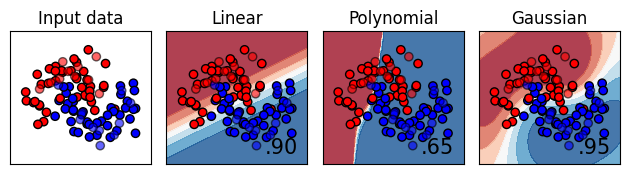

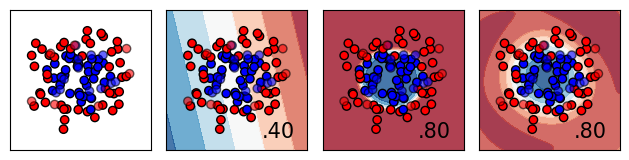

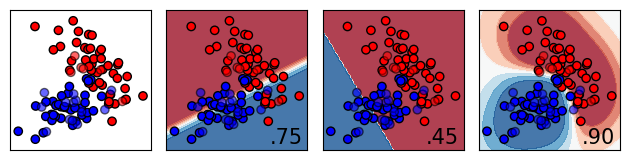

In [5]:

#figure = plt.figure(figsize=(27, 9))
i = 1


for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # The first columns plots the data.
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(kernels_fn) + 1, i)
    if ds_cnt == 0:
      ax.set_title("Input data")

    ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(
        x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    i += 1

    # iterate over classifiers
    for name, K in zip(names, kernels_fn):
        ax = plt.subplot(len(datasets), len(kernels_fn) + 1, i)

        model_kernel = KernelLogisticRegression(K, lr=0.1, epochs=1000)
        model_kernel.fit(x_train, y_train)

        pred = model_kernel.predict(x_test)
        score = np.mean(pred == y_test)

        DecisionBoundaryDisplay.from_estimator(
            model_kernel, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            x_test[:, 0],
            x_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
          ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

    plt.tight_layout()
    plt.show()

In [6]:
alpha, hist = kernel_logistic_regression(X, y, lineal_kernel, 0.005, 500)

In [7]:
alpha, hist = kernel_logistic_regression(X, y, polynomial_kernel, 0.0005, 500)

In [8]:
alpha, hist = kernel_logistic_regression(X, y, gaussian_kernel, 0.01, 1000)

In [15]:
alpha.shape

TensorShape([100, 1])

## MNIST
We work with 1000 randoms samples of training set and 100 random samples for testing

In [11]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape,y_train.shape,x_test.shape,y_test.shape
np.random.seed(42)
n_samples_train=1000
indices = np.random.choice(len(x_train), n_samples_train, replace=False)
x_train=x_train[indices]
y_train=y_train[indices]
n_samples_test=100
indices = np.random.choice(len(x_test), n_samples_test, replace=False)
x_test=x_test[indices]
y_test=y_test[indices]
x_train.shape,y_train.shape,x_test.shape,y_test.shape
# Aplanar imágenes y normalizar
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

In [21]:
classes=np.unique(y_test)
n_classes=len(classes)

for name,K in zip(names,kernels_fn):
  for idx,val in enumerate(classes):
      print(f"Class {idx}: {val}")
      model_kernel = KernelLogisticRegression(K, lr=0.1, epochs=1000)
      y_binary = (y_train == val).astype(int)
      model_kernel.fit(x_train, y_binary)
      pred = model_kernel.predict(x_test)
      score = np.mean(pred == y_test)
      print(f"Score: {score}")



Class 0: 0
Score: 0.1
Class 1: 1
Score: 0.1
Class 2: 2
Score: 0.1
Class 3: 3
Score: 0.1
Class 4: 4
Score: 0.1
Class 5: 5
Score: 0.1
Class 6: 6
Score: 0.1
Class 7: 7
Score: 0.1
Class 8: 8
Score: 0.1
Class 9: 9
Score: 0.1
Class 0: 0
Score: 0.1
Class 1: 1
Score: 0.1
Class 2: 2
Score: 0.1
Class 3: 3
Score: 0.1
Class 4: 4
Score: 0.1
Class 5: 5
Score: 0.1
Class 6: 6
Score: 0.1
Class 7: 7
Score: 0.1
Class 8: 8
Score: 0.1
Class 9: 9
Score: 0.1
Class 0: 0
Score: 0.06
Class 1: 1
Score: 0.22
Class 2: 2
Score: 0.1
Class 3: 3
Score: 0.1
Class 4: 4
Score: 0.1
Class 5: 5
Score: 0.1
Class 6: 6
Score: 0.1
Class 7: 7
Score: 0.1
Class 8: 8
Score: 0.1
Class 9: 9
Score: 0.1
